In [1]:
# Install required packages
!pip install ultralytics supervision opencv-python numpy matplotlib -q


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\USER\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
# Import required libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import urllib.request
import os

from ultralytics import YOLO
import supervision as sv

In [5]:
# Video URL and paths
VIDEO_URL = "https://media.roboflow.com/supervision/video-examples/people-walking.mp4"
INPUT_VIDEO_PATH = "people-walking.mp4"
OUTPUT_VIDEO_PATH = "output_tracked.mp4"
HEATMAP_PATH = "heatmap.png"
HEATMAP_OVERLAY_PATH = "heatmap_overlay.png"

# Download the video
if not os.path.exists(INPUT_VIDEO_PATH):
    urllib.request.urlretrieve(VIDEO_URL, INPUT_VIDEO_PATH)
    print(f"Downloaded video to {INPUT_VIDEO_PATH}")
else:
    print(f"Video already exists at {INPUT_VIDEO_PATH}")
    
#Get video properties
cap = cv2.VideoCapture(INPUT_VIDEO_PATH)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
cap.release()
print(f"Video properties - Width: {width}, Height: {height}, FPS: {fps}, Total Frames: {total_frames}, Duration: {total_frames/fps:.2f} seconds")

Video already exists at people-walking.mp4
Video properties - Width: 1920, Height: 1080, FPS: 25.0, Total Frames: 341, Duration: 13.64 seconds


In [6]:
# Load YOLOv8 model
model = YOLO("yolov8n.pt")

# Configuration
CONFIDENCE_THRESHOLD = 0.3
PERSON_CLASS_ID = 0 # COCO class ID for person

In [7]:
# Initialize ByteTrack tracker
tracker = sv.ByteTrack(
    track_activation_threshold=0.25,
    minimum_matching_threshold=0.8,
    frame_rate=fps,
    lost_track_buffer=30
)

# Dictionary for person IDs
track_history = defaultdict(lambda: [])

In [8]:
# Define line positions
UPPER_LINE_Y_POS_PERCENT = 0.4
LOWER_LINE_Y_POS_PERCENT = 0.6

# Y Coordinates of the lines
upper_line_y = int(UPPER_LINE_Y_POS_PERCENT * height)
lower_line_y = int(LOWER_LINE_Y_POS_PERCENT * height)

# X axis points
LINE_START_X = 0
LINE_END_X = width

# Upper line zone
line_in_start = sv.Point(LINE_START_X, upper_line_y)
line_in_end = sv.Point(LINE_END_X, upper_line_y)
line_in_zone = sv.LineZone(start=line_in_start, end=line_in_end)

# Lower line zone
line_out_start = sv.Point(LINE_START_X, lower_line_y)
line_out_end = sv.Point(LINE_END_X, lower_line_y)
line_out_zone = sv.LineZone(start=line_out_start, end=line_out_end)

print("Coordinates :\n")
print(f"Upper line (IN) Y = {upper_line_y}px ({UPPER_LINE_Y_POS_PERCENT*100:.0f}% from top)")
print(f"Start : ({LINE_START_X}, {upper_line_y}) to End : ({LINE_END_X}, {upper_line_y})")
print(f"Lower line (OUT) Y = {lower_line_y}px ({LOWER_LINE_Y_POS_PERCENT*100:.0f}% from top)")
print(f"Start : ({LINE_START_X}, {lower_line_y}) to End : ({LINE_END_X}, {lower_line_y})")


Coordinates :

Upper line (IN) Y = 432px (40% from top)
Start : (0, 432) to End : (1920, 432)
Lower line (OUT) Y = 648px (60% from top)
Start : (0, 648) to End : (1920, 648)


In [9]:
def detect_people(frame, model, confidence_threshold=0.3):

    # Run YOLO inference
    results = model(frame, verbose=False)[0]
    
    # Convert to supervision Detections
    detections = sv.Detections.from_ultralytics(results)
    
    # Filter for person class only and apply confidence threshold
    mask = (detections.class_id == PERSON_CLASS_ID) & (detections.confidence >= confidence_threshold)
    detections = detections[mask]
    
    return detections


def track_detections(detections, tracker):

    tracked_detections = tracker.update_with_detections(detections)
    return tracked_detections


print("✅ Detection and tracking functions defined!")

✅ Detection and tracking functions defined!


*Counting Logic Implementation*

In [10]:
in_count = 0
out_count = 0

counted_in_ids = set()
counted_out_ids = set()

def update_counts(tracked_detections, track_history, upper_line_y,lower_line_y ):
    
    global in_count, out_count, counted_in_ids, counted_out_ids
    
    if tracked_detections is None or len(tracked_detections) == 0:
        return in_count, out_count
    
    for i, tracker_id in enumerate(tracked_detections.tracker_id):
        x1, y1, x2, y2 = tracked_detections.xyxy[i]
        center_x = int((x1 + x2) / 2)
        center_y = int((y1 + y2) / 2)
        
        if tracker_id in track_history and len(track_history[tracker_id]) > 0:
            prev_y = track_history[tracker_id][-1][1]
            
            if tracker_id not in counted_in_ids:
                if prev_y < upper_line_y and center_y >= upper_line_y:
                    in_count += 1
                    counted_in_ids.add(tracker_id)
                    
            if tracker_id not in counted_out_ids:
                if prev_y > lower_line_y and center_y <= lower_line_y:
                    out_count += 1
                    counted_out_ids.add(tracker_id)
        
        track_history[tracker_id].append((center_x, center_y))
        if len(track_history[tracker_id]) > 40:
            track_history[tracker_id].pop(0)
    return in_count, out_count

In [11]:
heatmap_accumulator = np.zeros((height, width), dtype=np.float32)

def update_heatmap(heatmap, detection, radius =30):
    
    for bbox in detection.xyxy:
        x1, y1, x2, y2 = bbox
        center_x = int((x1 + x2) / 2)
        center_y = int((y1 + y2) / 2)
        
        y_min = max(0, center_y - radius)
        y_max = min(heatmap.shape[0], center_y + radius)
        x_min = max(0, center_x - radius)
        x_max = min(heatmap.shape[1], center_x + radius)
        
        for y in range(y_min, y_max):
            for x in range(x_min, x_max):
                d = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)
                if d < radius:
                    weight = np.exp(-(d ** 2) / (2 * (radius / 2) ** 2))
                    heatmap[y, x] += weight
    return heatmap


In [14]:
# Annotate
box_annotator = sv.BoxAnnotator(
    thickness=2,
    color=sv.Color.from_hex("#AD0079")
)

label_annotator = sv.LabelAnnotator(
    text_position=sv.Position.TOP_CENTER,
    text_thickness=1,
    text_scale=0.5,
    text_color=sv.Color.from_hex("#AD0000")
)

line_annotator_in = sv.LineZoneAnnotator(
    thickness=3,
    text_thickness=2,
    text_scale=1,
    color=sv.Color.from_hex("#00FF00") 
)

line_annotator_out = sv.LineZoneAnnotator(
    thickness=3,
    text_thickness=2,
    text_scale=1,
    color=sv.Color.from_hex("#FF0000") 
)


trace_annotator = sv.TraceAnnotator(
    thickness=2,
    color=sv.Color.from_hex("#FFFF00"),
    trace_length = 30,
    position=sv.Position.CENTER
)


def draw_counter_overlay(frame, in_count, out_count):
    
    overlay = frame.copy()
    
    box_width = 200
    box_height = 80
    padding = 10
    
    cv2.rectangle(overlay, (padding, padding), (padding + box_width, padding + box_height), (0, 0, 0), -1)
    alpha = 0.6
    
    frame = cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0)
    cv2.putText(frame, f"IN: {in_count}", (padding + 10, padding + 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
    cv2.putText(frame, f"OUT: {out_count}", (padding + 10, padding + 60), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
    return frame


def draw_lines(frame, upper_line_y, lower_line_y):
    
    cv2.line(frame,(0,upper_line_y),(width,upper_line_y),(0,255,0),2)
    cv2.putText(frame, 'IN LINE', (10, upper_line_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)
    cv2.line(frame,(0,lower_line_y),(width,lower_line_y),(0,0,255),2)
    cv2.putText(frame, 'OUT LINE', (10, lower_line_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)
    return frame


In [16]:
in_count = 0
out_count = 0
counted_in_ids = set()
counted_out_ids = set()
heatmap_accumulator = np.zeros((height, width), dtype=np.float32)
track_history = defaultdict(lambda: [])

# Re-initialize tracker
tracker = sv.ByteTrack(
    track_activation_threshold=0.25,
    minimum_matching_threshold=0.8,
    frame_rate=fps,
    lost_track_buffer=30
)

cap = cv2.VideoCapture(INPUT_VIDEO_PATH)
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(OUTPUT_VIDEO_PATH, fourcc, fps, (width, height))
#last frame for heatmap overlay
last_frame = None

print("Video processed")

Video processed


In [20]:
frame_count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    frame_count += 1
    last_frame = frame.copy()
    # Detect people
    detections = detect_people(frame, model, CONFIDENCE_THRESHOLD)
    
    # Track detections
    tracked_detections = track_detections(detections, tracker)
    
    # Update counts
    in_count, out_count = update_counts(tracked_detections, track_history, upper_line_y, lower_line_y)
    
    # Update heatmap
    heatmap_accumulator = update_heatmap(heatmap_accumulator, tracked_detections, radius=30)
    
    # Annotate frame
    annotated_frame = box_annotator.annotate(scene=frame, detections=tracked_detections)
    
    # Add labels with tracker IDs
    labels = [f"ID: {tracker_id}" for tracker_id in tracked_detections.tracker_id]
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=tracked_detections, labels=labels)
    
    # Draw movement traces
    annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=tracked_detections)
    
    # Draw counting lines
    annotated_frame = draw_lines(annotated_frame, upper_line_y, lower_line_y)
    
    # Draw counter overlay
    annotated_frame = draw_counter_overlay(annotated_frame, in_count, out_count)
    
    out.write(annotated_frame)
    
    # Progress per 100 frames
    if frame_count % 100 == 0:
        progress = (frame_count / total_frames) * 100
        print(f"   Progress: {progress:.1f}% ({frame_count}/{total_frames} frames) | IN: {in_count} | OUT: {out_count}")
        
cap.release()
out.release()


print(f"\nFinal Counts:")
print(f"    IN:  {in_count}")
print(f"    OUT: {out_count}")    

   Progress: 29.3% (100/341 frames) | IN: 8 | OUT: 6
   Progress: 58.7% (200/341 frames) | IN: 11 | OUT: 6

Final Counts:
    IN:  12
    OUT: 7


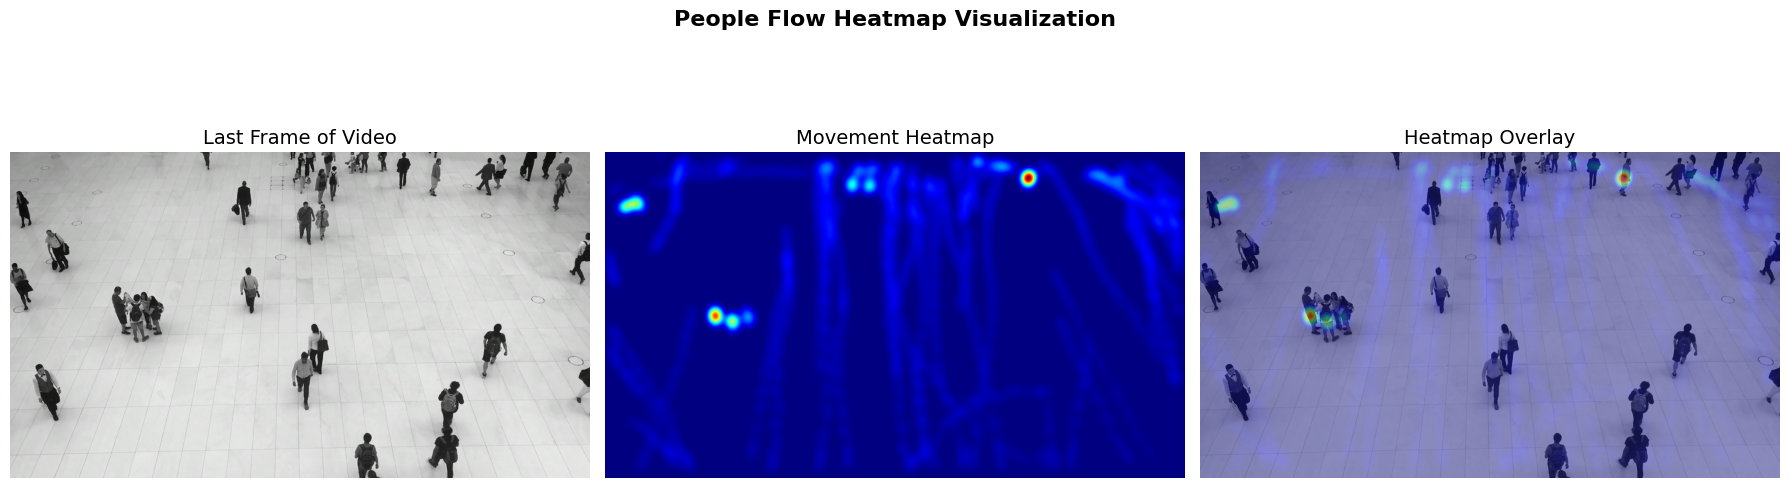

Blue -> Green -> Yellow -> Red indicates low to high movement density respectively.


In [28]:
# Gausssian Blur
heatmap_blurred = cv2.GaussianBlur(heatmap_accumulator, (51,51),0)

# Normalization
heatmap_normalized = cv2.normalize(heatmap_blurred, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Apply colormap(blue-> green-> yellow-> red)
heatmap_colored = cv2.applyColorMap(heatmap_normalized, cv2.COLORMAP_JET)

fig, axes = plt.subplots(1,3, figsize=(18,6))

# Original last frame
axes[0].imshow(cv2.cvtColor(last_frame, cv2.COLOR_BGR2RGB))
axes[0].set_title("Last Frame of Video",fontsize=14)
axes[0].axis("off")

# Hetmap only
axes[1].imshow(cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB))
axes[1].set_title("Movement Heatmap",fontsize=14)
axes[1].axis("off")

# Overlay heatmap on frame
overlay = cv2.addWeighted(last_frame, 0.6, heatmap_colored, 0.4, 0)
axes[2].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
axes[2].set_title("Heatmap Overlay",fontsize=14)
axes[2].axis("off")

plt.suptitle('People Flow Heatmap Visualization', fontsize=16,fontweight='bold')
plt.tight_layout()
plt.show()

print("Blue -> Green -> Yellow -> Red indicates low to high movement density respectively.")

In [ ]:
# Save hetmap images
cv2.imwrite(HEATMAP_PATH, heatmap_colored)
# Save overlay image
cv2.imwrite(HEATMAP_OVERLAY_PATH, overlay)


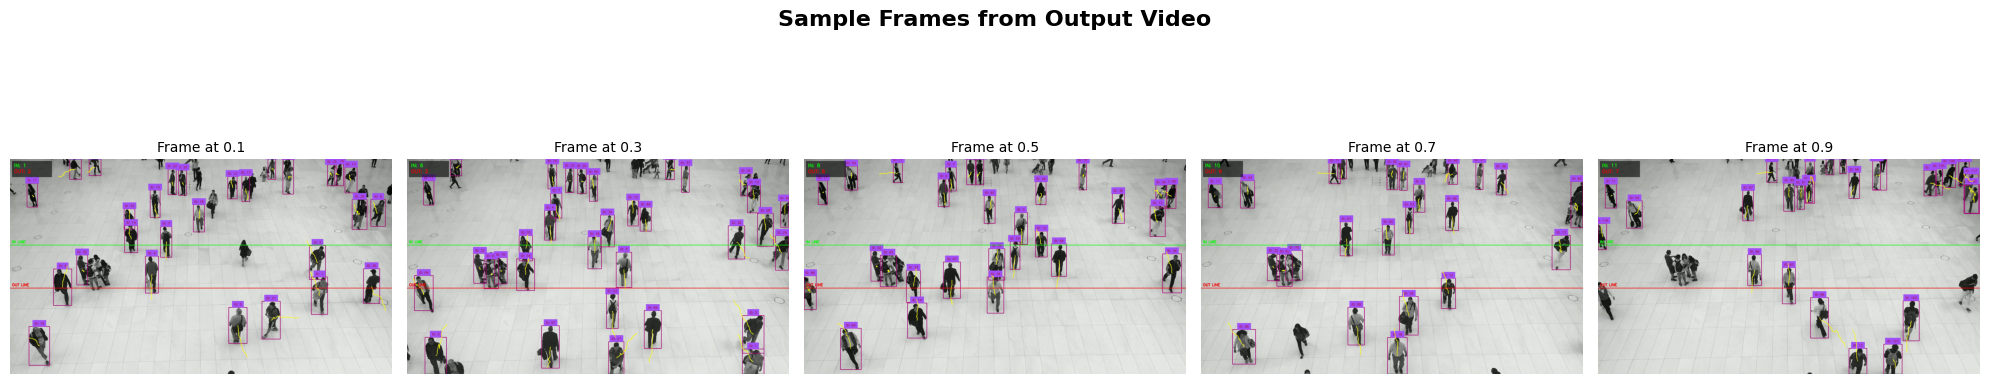

In [29]:
# Dsiplay sample frames

cap = cv2.VideoCapture(OUTPUT_VIDEO_PATH)

sample_frames = []
sample_positions = [0.1,0.3,0.5,0.7,0.9]  # 10%, 30%, 50%, 70%, 90%

for pos in sample_positions:
    frame_number = int(pos * total_frames)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    if ret:
        sample_frames.append((pos, frame))
cap.release()

fig, axes = plt.subplots(1, len(sample_frames), figsize=(20,5))
for i, (frame_number, frame) in enumerate(sample_frames):
    axes[i].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    axes[i].set_title(f"Frame at {frame_number}", fontsize=10)
    axes[i].axis("off")
plt.suptitle('Sample Frames from Output Video', fontsize=16,fontweight='bold')
plt.tight_layout()
plt.show()